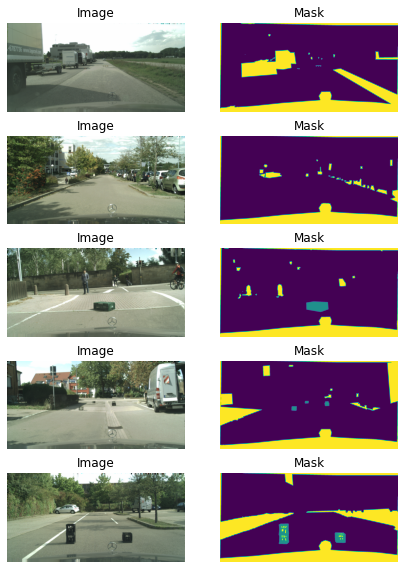

In [1]:

glob_mask = None
#@title Imports and Setup
import bdlb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import numpy as np
import random

random_seed = 304
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

gts = []

def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  fig, axs = plt.subplots(num_samples, 2, figsize=(7, 2*num_samples))
  for i, blob in enumerate(tfdataset.take(num_samples)):
    image = blob['image_left'].numpy()
    
    mask = blob['mask'].numpy()
    axs[i][0].imshow(image.astype('int'))
    axs[i][0].axis("off")
    axs[i][0].set(title="Image")
    # map 255 to 2 such that difference between labels is better visible
    
    mask[mask == 255] = 2
    mask[mask == 1] = 1
    
    gts.append(mask)
    
    axs[i][1].imshow(mask[..., 0])
    axs[i][1].axis("off")
    axs[i][1].set(title="Mask")
    
    
  fig.show()



fs = bdlb.load(benchmark="fishyscapes", download_and_prepare=False)
# load the dataset, there is only a validation dataset
ds = fs.get_dataset('LostAndFound')
#ds = fs.get_dataset('Static')
visualize_tfdataset(ds, 5)

In [2]:
#Method	Backbone	Crop Size	Lr schd	Mem (GB)	Inf time (fps)	mIoU
mmseg_home = '/notebooks/3Project/0_KU-KAIST/driving_anomaly/mmsegmentation'
is_danet = True

#DNL		R-101-D8	512x1024	80000		-		-		80.41
#save_file = 'dnlnet'
#config_file = mmseg_home+'/configs/dnlnet/dnl_r101-d8_512x1024_80k_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/dnl_r101-d8_512x1024_80k_cityscapes_20200904_233629-758e2dd4.pth'

#SML only 
#SML + Var 
#Var only 

#OCRNet	HRNetV2p-W48	512x1024	160000	-		-		81.35
#save_file = 'ocrnet'
#config_file = mmseg_home+'/configs/ocrnet/ocrnet_hr48_512x1024_160k_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth'

#SML only
#SML + Var
#Var only

#OCRNet	R-101-D8	512x1024	80000		8.8		3.02		80.81
#save_file = 'ocrnet_r101'
#config_file = mmseg_home+'/configs/ocrnet/ocrnet_r101-d8_512x1024_80k_b16_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/ocrnet_r101-d8_512x1024_80k_b16_cityscapes_20200723_192421-78688424.pth'

#SML only
#SML + Var
#Var only

#ISANet		R-101-D8	769x769	80000		10.815		0.92		80.61
#save_file = 'ISANet'
#config_file = mmseg_home+'/configs/isanet/isanet_r101-d8_769x769_80k_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/isanet_r101-d8_769x769_80k_cityscapes_20210903_111319-24f71dfa.pth'

#SML only
#SML + Var
#Var only

#DANet		R-101-D8	512x1024	40000		10.9		1.99		80.52
save_file = 'DANet'
config_file = mmseg_home+'/configs/danet/danet_r101-d8_512x1024_40k_cityscapes.py'
checkpoint_file = mmseg_home+'/checkpoints/danet_r101-d8_512x1024_40k_cityscapes_20200605_200831-c57a7157.pth'

#SML only
#SML + Var
#Var only

#UPerNet	R-101		769x769	80000		-		-		80.10
#save_file = 'UPerNet'
#config_file = mmseg_home+'/configs/upernet/upernet_r101_769x769_80k_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/upernet_r101_769x769_80k_cityscapes_20200607_001014-082fc334.pth'

#SML only
#SML + Var
#Var only

#DeepLabV3	R-101-D8	512x1024	80000		5.75		3.86		80.48 없음?
#save_file = 'DeepLabV3'
#config_file = mmseg_home+'/configs/deeplabv3/deeplabv3_r101-d8_fp16_512x1024_80k_cityscapes.py'
#checkpoint_file = mmseg_home+'/checkpoints/deeplabv3_r101-d8_fp16_512x1024_80k_cityscapes_20200717_230920-774d9cec.pth'

#SML only
#SML + Var
#Var only


In [3]:

from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette


# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

features_t = []
def hook_t(module, input, output):
    features_t.append(input)
    features_t.append(output)


if "CascadeEncoderDecoder" in str(model.__class__):
    model.decode_head[-1].conv_seg.register_forward_hook(hook_t)
else:
    model.decode_head.conv_seg.register_forward_hook(hook_t)



Use load_from_local loader


In [6]:
import module.network as network
from module.config import cfg, assert_and_infer_cfg
import module.optimizer as optimizer

import argparse
import torch
import sys


sys.argv = ['hello.py']

parser = argparse.ArgumentParser(description='Semantic Segmentation')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--arch', type=str, default='network.deepv3.DeepR101V3PlusD_OS8',
                    help='Network architecture. We have DeepSRNX50V3PlusD (backbone: ResNeXt50) \
                    and deepWV3Plus (backbone: WideResNet38).')
parser.add_argument('--dataset', nargs='*', type=str, default='cityscapes',
                    help='a list of datasets; cityscapes')
parser.add_argument('--image_uniform_sampling', action='store_true', default=False,
                    help='uniformly sample images across the multiple source domains')
parser.add_argument('--val_dataset', nargs='*', type=str, default='cityscapes',
                    help='a list consists of cityscapes')
parser.add_argument('--val_interval', type=int, default=100000, help='validation interval')
parser.add_argument('--cv', type=int, default=0,
                    help='cross-validation split id to use. Default # of splits set to 3 in config')
parser.add_argument('--class_uniform_pct', type=float, default=0,
                    help='What fraction of images is uniformly sampled')
parser.add_argument('--class_uniform_tile', type=int, default=1024,
                    help='tile size for class uniform sampling')
parser.add_argument('--coarse_boost_classes', type=str, default=None,
                    help='use coarse annotations to boost fine data with specific classes')

parser.add_argument('--img_wt_loss', action='store_true', default=False,
                    help='per-image class-weighted loss')
parser.add_argument('--cls_wt_loss', action='store_true', default=False,
                    help='class-weighted loss')
parser.add_argument('--batch_weighting', action='store_true', default=False,
                    help='Batch weighting for class (use nll class weighting using batch stats')

parser.add_argument('--jointwtborder', action='store_true', default=False,
                    help='Enable boundary label relaxation')
parser.add_argument('--strict_bdr_cls', type=str, default='',
                    help='Enable boundary label relaxation for specific classes')
parser.add_argument('--rlx_off_iter', type=int, default=-1,
                    help='Turn off border relaxation after specific epoch count')
parser.add_argument('--rescale', type=float, default=1.0,
                    help='Warm Restarts new learning rate ratio compared to original lr')
parser.add_argument('--repoly', type=float, default=1.5,
                    help='Warm Restart new poly exp')

parser.add_argument('--fp16', action='store_true', default=False,
                    help='Use Nvidia Apex AMP')
parser.add_argument('--local_rank', default=0, type=int,
                    help='parameter used by apex library')

parser.add_argument('--sgd', action='store_true', default=True)
parser.add_argument('--adam', action='store_true', default=False)
parser.add_argument('--amsgrad', action='store_true', default=False)
parser.add_argument('--freeze_trunk', action='store_true', default=False)

parser.add_argument('--hardnm', default=0, type=int,
                    help='0 means no aug, 1 means hard negative mining iter 1,' +
                    '2 means hard negative mining iter 2')

parser.add_argument('--trunk', type=str, default='resnet101',
                    help='trunk model, can be: resnet101 (default), resnet50')
parser.add_argument('--max_epoch', type=int, default=180)
parser.add_argument('--max_iter', type=int, default=30000)
parser.add_argument('--max_cu_epoch', type=int, default=100000,
                    help='Class Uniform Max Epochs')
parser.add_argument('--start_epoch', type=int, default=0)
parser.add_argument('--crop_nopad', action='store_true', default=False)
parser.add_argument('--rrotate', type=int,
                    default=0, help='degree of random roate')
parser.add_argument('--color_aug', type=float,
                    default=0.0, help='level of color augmentation')
parser.add_argument('--gblur', action='store_true', default=False,
                    help='Use Guassian Blur Augmentation')
parser.add_argument('--bblur', action='store_true', default=False,
                    help='Use Bilateral Blur Augmentation')
parser.add_argument('--lr_schedule', type=str, default='poly',
                    help='name of lr schedule: poly')
parser.add_argument('--poly_exp', type=float, default=0.9,
                    help='polynomial LR exponent')
parser.add_argument('--bs_mult', type=int, default=2,
                    help='Batch size for training per gpu')
parser.add_argument('--bs_mult_val', type=int, default=1,
                    help='Batch size for Validation per gpu')
parser.add_argument('--crop_size', type=int, default=720,
                    help='training crop size')
parser.add_argument('--pre_size', type=int, default=None,
                    help='resize image shorter edge to this before augmentation')
parser.add_argument('--scale_min', type=float, default=0.5,
                    help='dynamically scale training images down to this size')
parser.add_argument('--scale_max', type=float, default=2.0,
                    help='dynamically scale training images up to this size')
parser.add_argument('--weight_decay', type=float, default=5e-4)
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--snapshot', type=str, default='data/r101_os8_base_cty.pth')
parser.add_argument('--restore_optimizer', action='store_true', default=False)

parser.add_argument('--city_mode', type=str, default='train',
                    help='experiment directory date name')
parser.add_argument('--date', type=str, default='default',
                    help='experiment directory date name')
parser.add_argument('--exp', type=str, default='default',
                    help='experiment directory name')
parser.add_argument('--tb_tag', type=str, default='',
                    help='add tag to tb dir')
parser.add_argument('--ckpt', type=str, default='logs/ckpt',
                    help='Save Checkpoint Point')
parser.add_argument('--tb_path', type=str, default='logs/tb',
                    help='Save Tensorboard Path')
parser.add_argument('--syncbn', action='store_true', default=True,
                    help='Use Synchronized BN')
parser.add_argument('--dump_augmentation_images', action='store_true', default=False,
                    help='Dump Augmentated Images for sanity check')
parser.add_argument('--test_mode', action='store_true', default=False,
                    help='Minimum testing to verify nothing failed, ' +
                    'Runs code for 1 epoch of train and val')
parser.add_argument('-wb', '--wt_bound', type=float, default=1.0,
                    help='Weight Scaling for the losses')
parser.add_argument('--maxSkip', type=int, default=0,
                    help='Skip x number of  frames of video augmented dataset')
parser.add_argument('--scf', action='store_true', default=False,
                    help='scale correction factor')
parser.add_argument('--dist_url', default='tcp://127.0.0.1:', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--backbone_lr', type=float, default=0.0,
                    help='different learning rate on backbone network')

parser.add_argument('--pooling', type=str, default='mean',
                    help='pooling methods, average is better than max')

parser.add_argument('--ood_dataset_path', type=str,
                    default='/home/nas1_userB/dataset/ood_segmentation/fishyscapes',
                    help='OoD dataset path')

# Anomaly score mode - msp, max_logit, standardized_max_logit
parser.add_argument('--score_mode', type=str, default='blending_test',
                    help='score mode for anomaly [msp, max_logit, standardized_max_logit]')

# Boundary suppression configs
parser.add_argument('--enable_boundary_suppression', type=bool, default=True,
                    help='enable boundary suppression')
parser.add_argument('--boundary_width', type=int, default=4,
                    help='initial boundary suppression width')
parser.add_argument('--boundary_iteration', type=int, default=4,
                    help='the number of boundary iterations')

# Dilated smoothing configs
parser.add_argument('--enable_dilated_smoothing', type=bool, default=True,
                    help='enable dilated smoothing')
parser.add_argument('--smoothing_kernel_size', type=int, default=7,
                    help='kernel size of dilated smoothing')
parser.add_argument('--smoothing_kernel_dilation', type=int, default=6,
                    help='kernel dilation rate of dilated smoothing')

args = parser.parse_args()

In [7]:
#https://github.com/shjung13/Standardized-max-logits/blob/main/calculate_statistics.py


from tqdm import tqdm
import torch.nn.functional as F

def calculate_statistics(train_loader):
    """
    Runs the training loop per epoch
    train_loader: Data loader for train
    net: thet network
    return:
    """
    global features_t
    model.backbone.eval()
    model.decode_head.eval()
    
    pred_list = None
    max_class_mean = {}
    print("Calculating statistics...")
    
    import os.path
    
    if os.path.isfile(f'stats/cityscapes_mean_'+save_file+'.npy'):
        print("Skip calc.")
        return None
        
    
    for i, data in tqdm(enumerate(train_loader)):
        inputs = data[0]

        inputs = inputs.cuda()
        B, C, H, W = inputs.shape
        batch_pixel_size = C * H * W
        
        with torch.no_grad():
            features_t.clear()
            
            if "CascadeEncoderDecoder" in str(model.__class__):
                x = model.backbone(inputs)
                out = model.decode_head[0](x)
                for j in range(1, model.num_stages):
                    out = model.decode_head[j](x, out)
            else:
                x = model.backbone(inputs)
                out = model.decode_head(x)
            
            out = features_t[-1]
            
            #if type(out) == tuple:
            #    out = out[0]
                
            outputs = out
            outputs = F.interpolate(outputs, size=(1024, 2048), mode='bilinear', align_corners=True)
            
        if pred_list is None:
            pred_list = outputs.detach().data.cpu()
        else:
            pred_list = torch.cat((pred_list, outputs.detach().data.cpu()), 0)
        
        del x
        del outputs
        del inputs

        if i % 50 == 49 or i == len(train_loader) - 1: 
            pred_list = pred_list.transpose(1, 3)
            pred_list, prediction = pred_list.max(3)
            
            class_max_logits = []
            mean_dict, var_dict = {}, {}
            for c in range(19):
                max_mask = pred_list[prediction == c]
                class_max_logits.append(max_mask)

                mean = class_max_logits[c].mean(dim=0)
                var = class_max_logits[c].var(dim=0)

                mean_dict[c] = mean.item()
                var_dict[c] = var.item()

            print(f"class mean: {mean_dict}")
            print(f"class var: {var_dict}")
            np.save(f'stats/cityscapes_mean_'+save_file+'.npy', mean_dict)
            np.save(f'stats/cityscapes_var_'+save_file+'.npy', var_dict)

            return None
        
"""
data_transform = data_transforms(load_size=768, mean_train=mean_train, std_train=std_train)
val_data_transform = data_transforms(load_size=768, mean_train=mean_train, std_train=std_train)

dataset_path = '/notebooks/3Project/0_KU-KAIST/driving_anomaly/STPM_anomaly_detection/leftImg8bit'
image_datasets = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=data_transform)
val_image_datasets = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=val_data_transform)



dataloaders = DataLoader(val_image_datasets, batch_size=2, shuffle=True, num_workers=0) #, pin_memory=True)
val_dataloaders = DataLoader(val_image_datasets, batch_size=2, shuffle=True, num_workers=0) #, pin_memory=True)
dataset_sizes = {'train': len(image_datasets)}    
print('Dataset size : Train set - {}'.format(dataset_sizes['train']))   
"""
import module
args.dataset = ['cityscapes']
args.ngpu = 1
args.syncbn = False
args.val_dataset = []
train_loader, val_loaders, train_obj, extra_val_loaders = module.datasets.setup_loaders(args)
calculate_statistics(train_loader)


Calculating statistics...
Skip calc.


In [8]:
import numpy as np

class_mean = np.load(f'stats/cityscapes_mean_'+save_file+'.npy', allow_pickle=True).item()
class_var = np.load(f'stats/cityscapes_var_'+save_file+'.npy', allow_pickle=True).item()

#print(class_mean)
#print(class_var)

#class_mean = np.load(f'module/data/cityscapes_mean_reported.npy', allow_pickle=True).item()
#class_var = np.load(f'module/data/cityscapes_var_reported.npy', allow_pickle=True).item()

print(class_mean)
print(class_var)

{0: 10.772146224975586, 1: 9.53106689453125, 2: 9.18337345123291, 3: 8.794532775878906, 4: 7.77644157409668, 5: 8.011637687683105, 6: 7.445332050323486, 7: 7.866826057434082, 8: 9.455082893371582, 9: 9.418112754821777, 10: 9.519679069519043, 11: 8.223386764526367, 12: 7.7131667137146, 13: 10.052271842956543, 14: 11.198891639709473, 15: 9.316407203674316, 16: 11.537454605102539, 17: 7.78668737411499, 18: 7.594078540802002}
{0: 1.7882658243179321, 1: 2.794072151184082, 2: 2.0019116401672363, 3: 3.483675718307495, 4: 2.0385260581970215, 5: 2.900850296020508, 6: 2.029709577560425, 7: 2.684190273284912, 8: 1.6187807321548462, 9: 2.7548234462738037, 10: 1.362655758857727, 11: 3.7389979362487793, 12: 2.743023633956909, 13: 1.9637079238891602, 14: 2.665374517440796, 15: 3.1696243286132812, 16: 3.2935988903045654, 17: 2.51132869720459, 18: 2.336982011795044}


In [9]:
import math 
from scipy import ndimage as ndi
from kornia.morphology import dilation, erosion
import torch.nn as nn

def find_boundaries(label):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    """
    assert len(label.shape) == 4
    boundaries = (dilation(label.float(), selem_dilation) != erosion(label.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries

class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False)
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight)))

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False)
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel)


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)

selem = torch.ones((3, 3)).cuda()
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1)).cuda()

print(f'selem:\n\n{selem}')
print(f'selem_dilation:\n\n{selem_dilation}')

# NOTE(shjung13): Dilation filters to expand the boundary maps (L1)
d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1)).cuda()
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1)).cuda()
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1)).cuda()
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1)).cuda()
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1)).cuda()
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1)).cuda()
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1)).cuda()
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1)).cuda()
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1)).cuda()

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}


for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)

    print(f'dilation kernel at {k}:\n\n{d_ks[k]}')


selem:

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
selem_dilation:

tensor([[0., 1., 0.],
        [1., 1., 1.],
        [0., 1., 0.]], device='cuda:0')
dilation kernel at 1:

tensor([[0., 1., 0.],
        [1., 1., 1.],
        [0., 1., 0.]], device='cuda:0')
dilation kernel at 2:

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.]], device='cuda:0')
dilation kernel at 3:

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
dilation kernel at 4:

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 

In [10]:
multi_scale = BoundarySuppressionWithSmoothing(boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6).cuda()

In [11]:
from collections import namedtuple

# Based on https://github.com/mcordts/cityscapesScripts
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                 'has_instances', 'ignore_in_eval', 'color'])
classes = [
    CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    #CityscapesClass('license plate',        250, 255, 'vehicle', 7, False, True, (0, 0, 0)),
]
train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color.append([0, 0, 0])
train_id_to_color = np.array(train_id_to_color)
    
def decode_target(mask):
    """decode semantic mask to RGB image"""
    return train_id_to_color[mask]


In [12]:
import argparse
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
import numpy as np
import os
import glob
import shutil
import time
from torchvision.models import resnet18, resnet101
from PIL import Image
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_train = [0.485, 0.456, 0.406]
std_train = [0.229, 0.224, 0.225]



def val_data_transforms(load_size=256, mean_train=mean_train, std_train=std_train):
    data_transforms = transforms.Compose([
            #transforms.Resize((load_size, load_size), Image.ANTIALIAS),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_train,
                                std=std_train)
            ])
    return data_transforms

num = 0
mode = "var"
def estimator(image):
    global num
    global features_t
    global mode

    features_t.clear()
    """Assigns a random uncertainty per pixel."""
    val_data_transform = val_data_transforms(mean_train=mean_train, std_train=std_train)
    test_img = Image.fromarray(np.array(image))
    test_img = val_data_transform(test_img)
    test_img = torch.unsqueeze(test_img, 0).to(device)

    with torch.set_grad_enabled(False):
        
        if "CascadeEncoderDecoder" in str(model.__class__):
            x = model.backbone(test_img)
            out = model.decode_head[0](x)
            for j in range(1, model.num_stages):
                out = model.decode_head[j](x, out)
        else:
            x = model.backbone(test_img)
            out = model.decode_head(x)
        
        out = features_t[-1]
        #if type(out) == tuple:
        #    out = out[0]
                
        outputs = out
        main_out = F.interpolate(outputs, size=(1024, 2048), mode='bilinear', align_corners=True)
        
        anomaly_score, prediction = main_out.detach().max(1)
        
        
        for c in range(19):
            anomaly_score = torch.where(prediction == c,
                                        (anomaly_score - class_mean[c]) / np.sqrt(class_var[c]),
                                        anomaly_score)
        
        if mode == "var":
            anomaly_score = main_out.detach().var(1)
        elif mode == "sum"
            anomaly_score = anomaly_score + main_out.detach().var(1)
        elif mode == "max"
            anomaly_score = anomaly_score
        with torch.no_grad():
            anomaly_score = multi_scale(anomaly_score, prediction)
        
    out2 = anomaly_score
    
    logit2, predction01 = features_t[1].detach().cpu().max(1)
    
    new_logit = -out2.clone()
    
    feats =  features_t[0]
    
    new_logit = new_logit.unsqueeze(1)
    new_logit = F.interpolate(new_logit, size=(feats[0].shape[2], feats[0].shape[3]), mode='bilinear', align_corners=True)
    new_logit = new_logit.squeeze(1)
    
    new_logit -= torch.min(new_logit)
    new_logit /= torch.max(new_logit)
    
    maps = torch.ones(1, feats[0].shape[2], feats[0].shape[3])
    
    if type(feats) == tuple:
        feats = feats[0]
    
    for i in range(3):
        feats = (((1-new_logit.cuda()) * feats) + ((new_logit.cuda()) * torch.max(feats) ))
        #print(feats.shape)
        if "CascadeEncoderDecoder" in str(model.__class__):
            output = model.decode_head[-1].conv_seg(feats)
        else:
            output = model.decode_head.conv_seg(feats)
        
        anomaly_score, _ = output.detach().max(1)
        new_logit = anomaly_score.detach().cpu()
        
        new_logit = new_logit.detach().cpu()
        new_logit -= torch.min(new_logit)
        new_logit /= torch.max(new_logit)
        
        
        maps[:] = new_logit

    
    new_logit = maps
    new_logit = new_logit.unsqueeze(1)
    new_logit = F.interpolate(new_logit, size=(1024, 2048), mode='bilinear', align_corners=True)
    new_logit = new_logit.squeeze(1)
    
    new_logit = new_logit[0]
    new_logit -= torch.min(new_logit)
    new_logit /= torch.max(new_logit)
    
    
    out3 = out2
    
    out3 = -out3.detach().cpu()[0]
        
    
    norm_logit = new_logit
    final_output = out3 * (1-norm_logit)
    
    return torch.tensor(final_output.detach().cpu())

metrics = fs.evaluate(estimator, ds.take(100))

print("AP: " + str(metrics['AP']) + " FPR95: " + str(metrics['FPR@95%TPR']) +  " auroc: " + str(metrics['auroc']))

0it [00:00, ?it/s]hello.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100it [00:39,  2.54it/s]


AP: 0.08263199386302018 FPR95: 0.79487747262549 auroc: 0.7974889947468489
